In [37]:
import numpy as np 

def GetSpectralIndex(E_min, E_max):
    """
    Returns the spectal index between evaluated at the two endpoints E_min and E_max based on the
    full-sky averaged P7REPv15 diffuse model spectrum

    :param E_min: Min energy in MeV
    :param E_max: Max energy in MeV
    :return spectral index: The power law index averaged over the given energy (positive value).
    """
    E = np.array([58.473133087158203, 79.970359802246108, 109.37088726489363, 149.58030713742139, 204.57243095354417,
                  279.7820134691566, 382.64185792772452, 523.31738421248383, 715.71125569520109, 978.83734991844688,
                  1338.6998597146596, 1830.8632323330951, 2503.9669281982829, 3424.532355440329, 4683.5370393234753,
                  6405.4057377695362, 8760.3070758200847, 11980.97094929486, 16385.688725918291, 22409.769304923335,
                  30648.559770668966, 41916.282280063475, 57326.501908367274, 78402.17791960774, 107226.17459483664,
                  146647.10628359963, 200560.85990769751, 274295.61718814232, 375138.42752394517, 513055.37160154793])
    dnde = np.array([1.3259335, 0.94195729, 0.66580701, 0.46162829, 0.30296713, 0.18484889, 0.10698333, 0.059697378,
                     0.032260861, 0.01673951, 0.0082548652, 0.0039907703, 0.0018546022, 0.00082937587, 0.0003599966,
                     0.00015557533, 6.7215013e-05, 2.8863404e-05, 1.2341489e-05, 5.3399754e-06, 2.2966778e-06,
                     9.9477847e-07, 4.53333e-07, 2.1135656e-07, 9.9832157e-08, 4.6697188e-08, 2.1986754e-08,
                     1.0368451e-08, 5.0197251e-09, 2.4097735e-09])

    # Find bin and check bounds 
    E_bin_min, E_bin_max = int(np.argmin(np.abs(E-E_min))),  int(np.argmin(np.abs(E-E_max)))
    if E_bin_min == E_bin_max:
        E_bin_max = E_bin_min+1
    if E_bin_max >= len(dnde):
        E_bin_min, E_bin_max = len(dnde)-3, len(dnde)-1

    return -np.log(dnde[E_bin_min]/dnde[E_bin_max])/np.log(E[E_bin_min]/E[E_bin_max])



def GetPSF(E_min, E_max, psfFile):
    """
    Spectrally weight the PSF(E) and return the average.  The spectrum is taken to be the global average of the P7
    galdiffuse model.  In practice, the energy bins should be narrow enough that this is sufficient.

    :param E_min: Minimum energy in MeV to integrate
    :param E_max: Maximum energy in MeV to integrate
    :param psfFile: absolute path to an output file from gtpsf.
    :returns thetas, avgPSF: thetas is the angular distance in degrees. avgPSF is the spectrally averaged point-spread
    and has the same units as gtpsf output.
    """
    hdu = pyfits.open(psfFile)
    
    thetas = np.array([theta[0] for theta in hdu[2].data])
    energies = np.array([energy[0] for energy in hdu[1].data])
    PSFs = np.array([psf[2] for psf in hdu[1].data])
    
    E_min_bin = np.argmin(np.abs(energies-E_min))
    E_max_bin = np.argmin(np.abs(energies-E_max))+1
    
    if E_max_bin > len(PSFs): E_min_bin, E_max_bin = len(PSFs)-2, len(PSFs)-1

    weights = energies[E_min_bin:E_max_bin]**-GetSpectralIndex(E_min, E_max)
    return thetas, np.average(PSFs[E_min_bin:E_max_bin], weights=weights, axis=0)





##  This below is radial profile of the PSF.  We need to multiply by the solid angle to get the distribution of photon counts. 

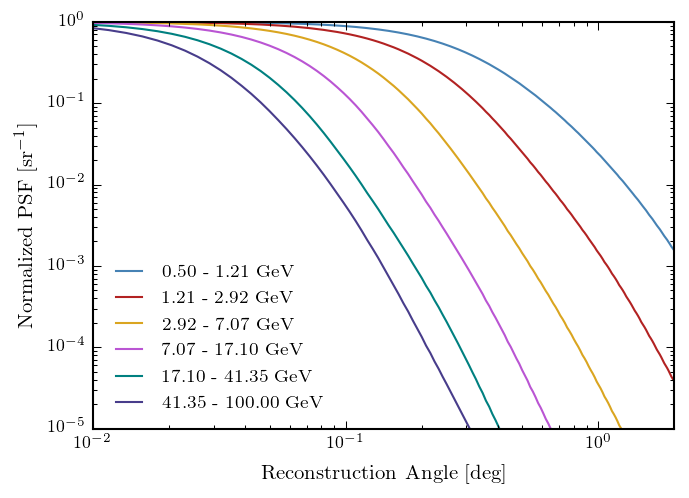

In [50]:

E_bins = np.load('../output/E_bins.npy') # Load our energy binning 

for i_E in range(len(E_bins)-1):
    thetas, PSF = GetPSF(E_bins[i_E]*1e3, E_bins[i_E+1]*1e3, '../fermi_output/gtpsf_P8R2_PSF3_CLEAN_wavelets.fits')
    plt.loglog(thetas, PSF/np.max(PSF), label=r' %1.2f - %1.2f GeV'%(E_bins[i_E],E_bins[i_E+1]))
plt.xlim(1e-2,2)
plt.ylim(1e-5, 1)

plt.legend(frameon=False, loc=3)
plt.ylabel('Normalized PSF [sr$^{-1}$]')
plt.xlabel('Reconstruction Angle [deg]')

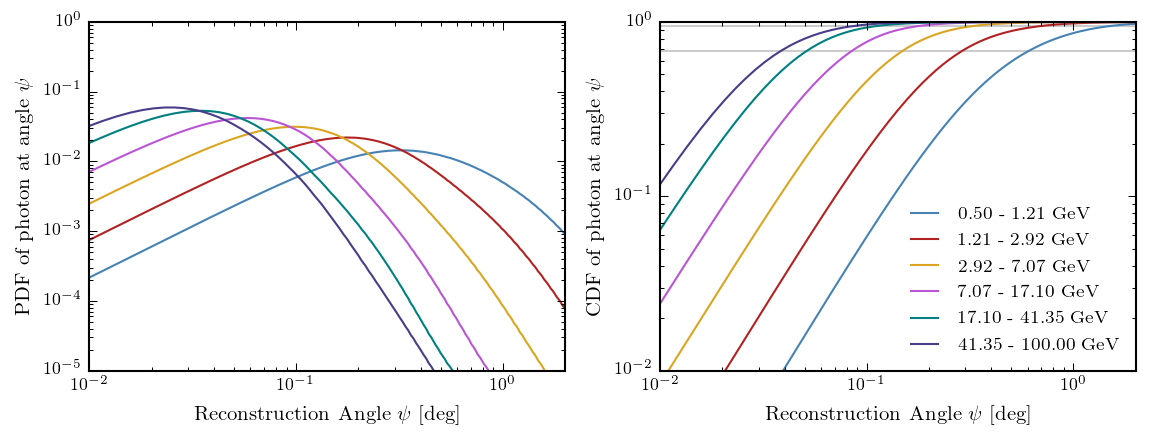

In [92]:
plt.figure(figsize=(9,3))

for i_E in range(len(E_bins)-1):
    thetas, PSF = GetPSF(E_bins[i_E]*1e3, E_bins[i_E+1]*1e3, '../fermi_output/gtpsf_P8R2_PSF3_CLEAN_wavelets.fits')
    PSF[:-1] = PSF[:-1] * thetas[:-1] *(thetas[1:]-thetas[:-1]) *2*np.pi * (np.pi/180.)**2 # PDF = integral{ PSF * 2pi r dr } 
    plt.subplot(1,2,1)
    plt.loglog(thetas, PSF/np.sum(PSF), label=r' %1.2f - %1.2f GeV'%(E_bins[i_E],E_bins[i_E+1]))
    plt.subplot(1,2,2)
    plt.loglog(thetas, np.cumsum(PSF)/np.sum(PSF), label=r' %1.2f - %1.2f GeV'%(E_bins[i_E],E_bins[i_E+1]))


plt.subplot(1,2,1)
plt.ylabel('PDF of photon at angle $\psi$')
plt.xlabel('Reconstruction Angle $\psi$ [deg]')
plt.xlim(1e-2,2)
plt.ylim(1e-5, 1)

plt.subplot(1,2,2)
plt.legend(frameon=False, loc=4)
plt.ylabel('CDF of photon at angle $\psi$')
plt.xlabel('Reconstruction Angle $\psi$ [deg]')
plt.xlim(1e-2,2)
plt.ylim(1e-2, 1)
plt.hlines([.68,.95], 1e-2, 2, alpha=.2)

1.01094792756
